In [6]:
import pandas as pd
import umap


In [7]:
# Cambia la ruta por la de tu CSV
df_pca = pd.read_csv("../../dimensionality_reduction/output_pca/X_train_pca_k553.csv")  
df_test = pd.read_csv("../../dimensionality_reduction/output_pca/X_test_pca_k553.csv")

# Si solo quieres los valores numéricos:
X_pca = df_pca.values
X_test = df_test.values
# Inicializamos UMAP para reducir a 2D (para visualización)
reducer = umap.UMAP(n_components=2, random_state=42)

# Ajustamos y transformamos los datos
X_umap_train = reducer.fit_transform(X_pca)
X_umap_test = reducer.fit_transform(X_test)
# X_umap ahora es un array de shape (n_samples, 2)
df_umap_train = pd.DataFrame(X_umap_train, columns=['UMAP1', 'UMAP2'])
df_umap_train.to_csv("X_umap_train.csv", index=False)

df_umap_test = pd.DataFrame(X_umap_test, columns=['UMAP1', 'UMAP2'])
df_umap_test.to_csv("X_umap_test.csv", index=False)

c:\Users\laura\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


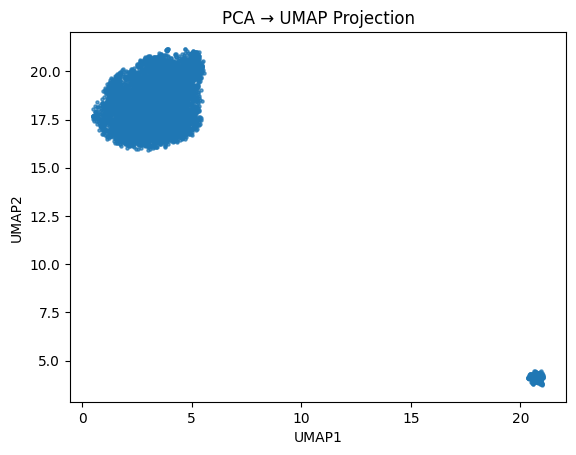

In [8]:
import matplotlib.pyplot as plt

plt.scatter(df_umap_train['UMAP1'], df_umap_train['UMAP2'], s=5, alpha=0.7)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("PCA → UMAP Projection")
plt.show()

In [9]:
import numpy as np
import pandas as pd

def kmeans(X, k=5, max_iters=100, tolerance=1e-4, random_state=42, save_path=None):

    np.random.seed(random_state)

    # === Inicialización de centroides ===
    indices = np.random.choice(X.shape[0], k, replace=False)
    centroids = X[indices]

    for iteration in range(max_iters):
        # === Asignar cada punto al cluster más cercano ===
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        # === Recalcular centroides ===
        new_centroids = np.array([X[labels == j].mean(axis=0) for j in range(k)])

        # === Verificar convergencia ===
        shift = np.linalg.norm(new_centroids - centroids)
        if shift < tolerance:
            print(f" Convergencia alcanzada en iteración {iteration+1}")
            break

        centroids = new_centroids

    else:
        print(f" Se alcanzó el máximo de {max_iters} iteraciones sin converger")
    if save_path:
        pd.DataFrame(labels, columns=["cluster"]).to_csv(save_path, index=False)
        print(f" Etiquetas guardadas en '{save_path}'")

    print(f"\nTotal de iteraciones: {iteration+1}")
    print(f"Clusters encontrados: {len(np.unique(labels))}\n")

    return labels, centroids, iteration + 1

# Cargar tu dataset reducido
X = pd.read_csv("X_umap_train.csv").values

# Ejecutar K-Means
labels, centroids, iters = kmeans(X, k=5, max_iters=100, tolerance=1e-4, save_path="train_clusters_kmeans.csv")



 Convergencia alcanzada en iteración 13
 Etiquetas guardadas en 'train_clusters_kmeans.csv'

Total de iteraciones: 13
Clusters encontrados: 5



In [10]:
# cargar asignaciones de clusters
clusters = pd.read_csv("train_clusters_kmeans.csv")

# conteo de películas por cluster
print("=== Distribución de películas por cluster ===")
print(clusters['cluster'].value_counts().sort_index())

# porcentaje
print("\n=== Porcentaje de cada cluster ===")
print((clusters['cluster'].value_counts(normalize=True) * 100).round(2))


=== Distribución de películas por cluster ===
cluster
0     203
1    1089
2    1364
3    1196
4    1381
Name: count, dtype: int64

=== Porcentaje de cada cluster ===
cluster
4    26.39
2    26.07
3    22.85
1    20.81
0     3.88
Name: proportion, dtype: float64


In [11]:
from sklearn.metrics import silhouette_score
score = silhouette_score(X, labels)
print(f"Silhouette Score promedio: {score:.4f}")

Silhouette Score promedio: 0.4071


In [22]:
# === Celda 1: imports y rutas ===
import os
import numpy as np
import pandas as pd

DATA_DIR = "data/"
os.makedirs(DATA_DIR, exist_ok=True)

# Ajusta estos paths a lo que ya tienes:
PATH_MOVIES      = "X_trained_scaled_final.csv"                         # debe tener: movieId, title (opcional: year, genres, poster_path)
PATH_CLUSTERS    = "train_clusters_kmeans.csv"          # debe tener columna: cluster (N filas)
PATH_FEATURE_CSV = "X_trained_scaled_final_no_cat.csv"  # tu matriz N×D (con o sin movieId en la 1ra columna)

OUT_CSV = os.path.join(DATA_DIR, "movies_streamlit.csv")


In [23]:
# === Celda 2: cargar insumos ===
movies   = pd.read_csv(PATH_MOVIES)
clusters = pd.read_csv(PATH_CLUSTERS)
X_df     = pd.read_csv(PATH_FEATURE_CSV)

# Detectar si la primera columna de X es un ID
first_col = X_df.columns[0]
has_movie_id_in_X = first_col.lower() in ["movieid", "movie_id", "id"]

if has_movie_id_in_X:
    X_movie_ids = X_df[first_col].astype(int).to_numpy()
    X_values = X_df.drop(columns=[first_col]).to_numpy(dtype=float)
else:
    X_movie_ids = None
    X_values = X_df.to_numpy(dtype=float)

N, D = X_values.shape
print(f"Features: N={N}, D={D}")


Features: N=5233, D=1981


In [26]:
# === Celda 3: normalizar/validar y alinear ===
# Requisitos mínimos en movies
if "movieId" not in movies.columns:
    raise ValueError("El archivo movies.csv necesita la columna 'movieId'.")

# Alineación:
if X_movie_ids is not None:
    missing = set(X_movie_ids) - set(movies["movieId"].astype(int))
    if missing:
        raise ValueError(f"Hay movieId en X que no existen en movies: {list(missing)[:10]}")
    movies_aligned = movies.set_index("movieId").loc[X_movie_ids].reset_index()
else:
    if len(movies) != N:
        raise ValueError("X no tiene movieId y su longitud no coincide con movies. Alinea antes.")
    movies_aligned = movies.copy()


In [28]:
# === Celda 4: construir y guardar CSV único ===
# Columnas de features f0..f{D-1}
feat_cols = [f"f{i}" for i in range(D)]
features_df = pd.DataFrame(X_values, columns=feat_cols)

# Unir metadata + cluster + features
out_df = pd.concat(
    [
        movies_aligned[["movieId"]].reset_index(drop=True),
        clusters[["cluster"]].reset_index(drop=True),
        features_df.reset_index(drop=True)
    ],
    axis=1
)

out_df.to_csv(OUT_CSV, index=False)
print("✅ CSV generado para Streamlit:", OUT_CSV)
display(out_df.head())


✅ CSV generado para Streamlit: data/movies_streamlit.csv


,movieId,cluster,f0,f1,f2,f3,f4,f5,f6,f7,...,f1971,f1972,f1973,f1974,f1975,f1976,f1977,f1978,f1979,f1980
0,619,3,-0.600206,-0.645655,-0.602664,-0.378038,1.067803,1.111028,1.050618,1.370798,...,1.368683,-0.421627,0.666334,0.332284,-0.982296,0.047070,1.662756,0.039271,0.358310,-0.200255
1,33826,2,-0.661059,-0.742238,-0.820832,-0.882897,-0.979461,-0.990315,-1.012862,-1.014147,...,-0.685111,-0.381852,-0.659618,-1.206408,-0.404502,-0.898539,0.020805,-1.015907,-0.873081,-0.200308
2,1298,1,-0.131323,-0.022028,-0.272827,-0.211362,-0.261608,-0.218741,-0.375611,-0.223055,...,-0.118903,-0.395210,-0.380672,0.200233,0.077388,-0.492208,-0.761739,-0.301457,0.552874,-0.200191
3,140289,1,1.033471,-0.045341,-0.110494,-0.077297,-0.011161,0.049261,0.275802,0.288005,...,1.230976,1.204669,1.051461,1.063581,-0.837896,-0.299125,-0.089881,-0.615529,0.948941,-0.200325
4,3064,4,-0.489812,0.225258,3.103087,0.809225,1.525015,1.597529,1.309565,0.911078,...,1.250835,-0.381981,0.341583,0.174546,0.707916,-0.483436,-0.040400,-0.992591,-0.901765,-0.200274
